In [1]:
# https://archive.ics.uci.edu/dataset/445/absenteeism+at+work
# Install a pip package in the current Jupyter kernel
# Download the csv file
!python3 -m pip install gdown
!gdown --id 1ppW5XS4eV0-Eq8-DXbdu-QlyTF3h9yd_

!python3 -m pip install pandas
!python3 -m pip install numpy
!python3 -m pip install scikit-learn
!python3 -m pip install matplotlib

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ppW5XS4eV0-Eq8-DXbdu-QlyTF3h9yd_
To: /Users/matthewmartens/Projects/OU-Machine-Learning/Absenteeism_at_work.csv
100%|██████████████████████████████████████| 45.2k/45.2k [00:00<00:00, 47.3MB/s]


In [2]:
#import packages
import pandas as pd #for data-frames
import numpy as np #for matrix operatons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #split training and test
from sklearn.neighbors import KNeighborsClassifier #knn
from sklearn.metrics import roc_curve #roc
from sklearn.metrics import auc #auc
from sklearn.ensemble import RandomForestClassifier #random forest
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import scipy.stats as stats

In [3]:
#load the data and show the first lines
result = pd.read_csv("Absenteeism_at_work.csv", sep=';')
print(f"Total records in csv: {len(result)}")
result.sort_values("Absenteeism time in hours", ascending=False).head(10)

#result.value_counts("Reason for absence").sort_values(ignore_index=True)


Total records in csv: 740


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
323,14,11,11,2,4,155,12,14,34,284.031,...,0,1,2,1,0,0,95,196,25,120
729,9,6,7,3,1,228,14,16,58,264.604,...,0,1,2,0,0,1,65,172,22,120
420,36,13,4,4,3,118,13,18,50,239.409,...,0,1,1,1,0,0,98,178,31,120
471,28,9,7,3,1,225,26,9,28,230.290,...,0,1,1,0,0,2,69,169,24,112
622,9,12,3,3,2,228,14,16,58,222.196,...,0,1,2,0,0,1,65,172,22,112
652,11,19,3,2,3,289,36,13,33,222.196,...,0,1,2,1,0,1,90,172,30,104
734,13,13,7,2,1,369,17,12,31,264.604,...,0,1,3,1,0,0,70,169,25,80
569,14,18,12,3,2,155,12,14,34,280.549,...,0,1,2,1,0,0,95,196,25,80
231,36,13,6,4,3,118,13,18,50,377.550,...,0,1,1,1,0,0,98,178,31,80
682,26,19,5,6,3,300,26,13,43,237.656,...,0,1,2,1,1,1,77,175,25,64


<BarContainer object of 2 artists>

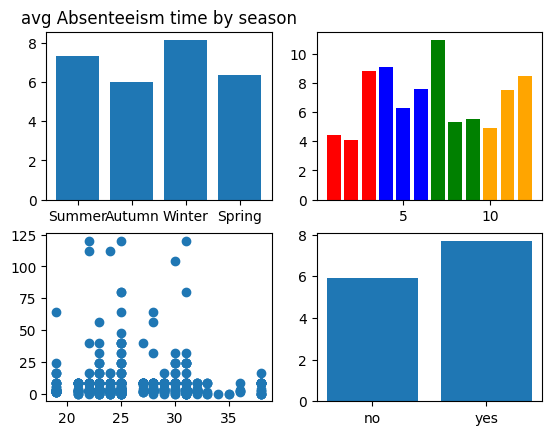

In [4]:
avarage_time_seaons = result.groupby(['Seasons'])['Absenteeism time in hours'].mean()
avarage_time_month = result.groupby(['Month of absence'])['Absenteeism time in hours'].mean()
socialdrinker_duration = result.groupby(['Social drinker'])['Absenteeism time in hours'].mean()
seasons = ("Summer", "Autumn", "Winter", "Spring")
fig, axs = plt.subplots(2,2)
axs[0,0].bar(seasons, avarage_time_seaons)
axs[0,0].set_title("avg Absenteeism time by season")
quarter_colors = ['red', 'blue', 'green', 'orange']
axs[0,1].bar(avarage_time_month.index[1:], avarage_time_month[1:], color=[color for color in quarter_colors for _ in range(3)])
axs[1,0].scatter(result.get('Body mass index'), result.get('Absenteeism time in hours'))
axs[1,1].bar(("no", "yes"), socialdrinker_duration)




In [5]:

result['hasMoreThan8Hours'] = np.where(result['Absenteeism time in hours']>8, 1, 0)
X = pd.get_dummies(result[['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Transportation expense',
                            'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day ', 'Disciplinary failure',
                            'Education', 'Son','Social drinker', 'Social smoker', 'Pet', 'Body mass index']])
y = pd.get_dummies(result[['hasMoreThan8Hours']]).hasMoreThan8Hours

print(y.value_counts())


hasMoreThan8Hours
0    677
1     63
Name: count, dtype: int64


In [212]:
#Repeating splitting, training and testing 1000 times takes a bit of time, so we do it in a different cell from the plotting
from multiprocessing import Process
allAcc = []
def nn(k, allAcc, amount = 100):
    acc = []
    for rs in list(range(0, amount-1)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs, stratify = y)
        clf = KNeighborsClassifier(n_neighbors = k)
        clf.fit(X_train.values, y_train.values)
        acc.append(clf.score(X_test.values, y_test.values))
    allAcc.append(acc)

def log(allAcc , amount = 1000):
    acc = []
    for rs in list(range(0, amount-1)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs, stratify = y)
        clf = LogisticRegression(random_state=rs, max_iter=3000)
        clf.fit(X_train.values, y_train.values)
        acc.append(clf.score(X_test.values, y_test.values))
    allAcc.append(acc)

def RFC(allAcc ,amount = 1000):
    acc = []
    for rs in list(range(0, amount-1)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs, stratify = y)
        clf = RandomForestClassifier(random_state=rs)
        clf.fit(X_train.values, y_train.values)
        acc.append(clf.score(X_test.values, y_test.values))
    allAcc.append(acc)

amount = 10
p1 = Process(target=nn(3, allAcc, amount))
p1.start()
p2 = Process(target=nn(5, allAcc, amount))
p2.start()
p3 = Process(target=log(allAcc, amount))
p3.start()
p4 = Process(target=RFC(allAcc, amount))
p4.start()
p1.join()
p2.join()
p3.join()
p4.join()

mean nn3 0.8978978978978981
mean nn5 0.9117117117117117
mean log 0.9063063063063063
mean rfc 0.9087087087087087


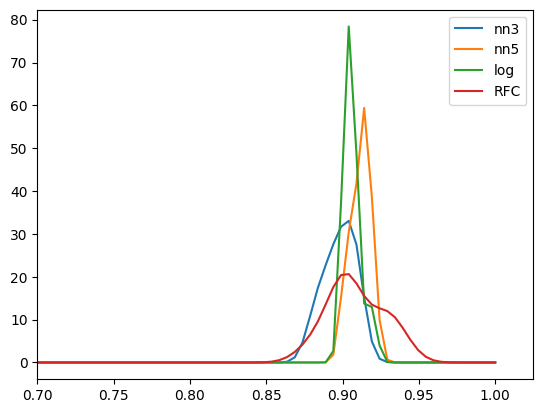

In [215]:
#plt.plot(acc5, color="blue")
density3 = stats.gaussian_kde(allAcc[0])
density5 = stats.gaussian_kde(allAcc[1])
densityLog = stats.gaussian_kde(allAcc[2])
densityRFC = stats.gaussian_kde(allAcc[3])
n3, x3, _ = plt.hist(allAcc[0], bins=np.linspace(0.5, 1, 100), 
                   histtype=u'step', density=True, ) 
n5, x5, _ = plt.hist(allAcc[1], bins=np.linspace(0.5, 1, 100), 
                   histtype=u'step', density=True, ) 
nLog, xLog, _ = plt.hist(allAcc[2], bins=np.linspace(0.5, 1, 100), 
                   histtype=u'step', density=True, ) 
nRFC, xRFC, _ = plt.hist(allAcc[3], bins=np.linspace(0.5, 1, 100), 
                   histtype=u'step', density=True, ) 
plt.close() 
plt.plot(x3, density3(x3))
plt.plot(x5, density5(x5))
plt.plot(xLog, densityLog(xLog))
plt.plot(xRFC, densityRFC(xRFC))
plt.legend(['nn3', 'nn5', 'log', 'RFC'])
plt.xlim(0.7)

print('mean nn3 '+str(np.mean(allAcc[0])))
print('mean nn5 '+str(np.mean(allAcc[1])))
print('mean log '+str(np.mean(allAcc[2])))
print('mean rfc '+str(np.mean(allAcc[3])))

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

clf = KNeighborsClassifier(n_neighbors = 5)
cv = StratifiedKFold(n_splits=20, random_state=None, shuffle=False)
scores = cross_val_score(clf, X, y, cv=cv)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


0.91 accuracy with a standard deviation of 0.03
